In [5]:
import numpy as np
import scipy.io as sio
import os
import euGenFuncs as eu
import matplotlib.pyplot as plt
%matplotlib inline
import imp 
import ieeg_funcs as ief
import pickle

In [9]:
from sklearn import svm
path_dict=ief.get_path_dict()
model_name='seSvmDsamp500TestFullFinal_2'
model_fname = os.path.join(path_dict['szr_ant_root'],'MODELS', model_name, 'classify_models_srch.pkl')
model = pickle.load(open(model_fname, 'rb'))
print(len(model))
print(np.sum(model[0].n_support_))

1
526


/Users/davidgroppe/anaconda/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
subs=[264, 273, 862, 1125]
#pth='/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/lregSeAes8_nokdsamp_1'
pth='/home/dgroppe/GIT/SZR_ANT/MODELS/svmAesFinale_1'
n_subs=len(subs)
try_thresh=np.arange(0.2,0.7,0.1)
n_thresh=len(try_thresh)

#preallocate mem
sens=np.zeros((n_subs, n_thresh))
total_hrs=np.zeros(n_subs)
total_clin_szrs=np.zeros(n_subs)
fp_per_day=np.zeros((n_subs, n_thresh))
mn_stim_lat=np.zeros((n_subs, n_thresh))

# Loop over files
for thresh_ct, thresh in enumerate(try_thresh):
    for sub_ct, sub in enumerate(subs):
        in_fname=str(sub)+'_thresh_0-'+str(int(10*thresh))+'_refract_30_stim_results.mat'
        npz=sio.loadmat(os.path.join(pth,in_fname))
        #in_fname=str(sub)+'_thresh_0-'+str(int(10*thresh))+'_refract_0-5_stim_results.npz'
        #npz=np.load(os.path.join(pth,in_fname))
        #sens[sub_ct,thresh_ct]=npz['sens']
        clin_szr_bool=npz['clin_szr']==1
        sens[sub_ct,thresh_ct]=np.mean(npz['szr_hit'][clin_szr_bool])
        fp_per_day[sub_ct,thresh_ct]=npz['fp_per_hour']*24
        mn_stim_lat[sub_ct,thresh_ct]=np.mean(npz['stim_lat'][clin_szr_bool])
        if thresh_ct==0:
            total_hrs[sub_ct]=npz['total_hrs']
            total_clin_szrs[sub_ct]=np.sum(clin_szr_bool)
            #total_clin_szrs[sub_ct]=npz['n_clin_szr']
print(npz.keys())
print('Mean SD sensitivity: %f (%f)' % (np.mean(sens),np.std(sens)))

dict_keys(['__header__', '__version__', '__globals__', 'stim_lat', 'stim_sec', 'clin_szr', 'szr_hit', 'total_hrs', 'n_false_pos', 'fp_per_hour', 'stim_thresh', 'refract_sec'])
Mean SD sensitivity: 0.987500 (0.037500)


In [11]:
print(npz.keys())
print(npz['szr_hit'])
print(npz['clin_szr'])

dict_keys(['__header__', '__version__', '__globals__', 'stim_lat', 'stim_sec', 'clin_szr', 'szr_hit', 'total_hrs', 'n_false_pos', 'fp_per_hour', 'stim_thresh', 'refract_sec'])
[[ 1.  1.  1.  1.  0.  1.  1.  1.  1.]]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  0.]]


In [16]:
# Report total hours of EEG & # of clinical szrs
print('Total hours of test data: %f' % np.sum(total_hrs))
print('Total days of test data: %f' % np.sum(total_hrs/24))
print('Mean (SD) days of test data: %f (%f)' % (np.mean(total_hrs/24),np.std(total_hrs/24)))
print('Total # of clinical szrs: %d' % np.sum(total_clin_szrs))
print('Mean (SD) # of clinical szrs: %f (%f)' % (np.mean(total_clin_szrs),np.std(total_clin_szrs)))

Total hours of test data: 689.958524
Total days of test data: 28.748272
Mean (SD) days of test data: 7.187068 (1.478903)
Total # of clinical szrs: 36
Mean (SD) # of clinical szrs: 9.000000 (2.915476)


For Thresh: 0.500000
Mean (SD) Sensitivity: 1.000000 (0.000000)


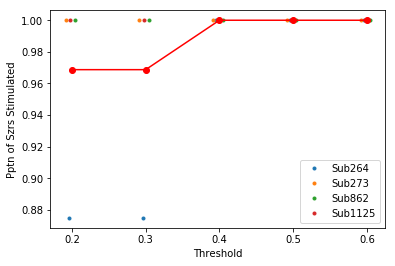

In [17]:
# Plot Sensitivity
plt.figure(1)
plt.clf()
for sub_ct in range(n_subs):
    plt.plot(try_thresh+(np.random.rand(1)-.5)/50,sens[sub_ct,:],'.',label='Sub'+str(subs[sub_ct]))
plt.plot(try_thresh,np.mean(sens,axis=0),'ro-')
plt.xlabel('Threshold')
plt.ylabel('Pptn of Szrs Stimulated')
plt.legend()

thresh_id=3
print('For Thresh: %f' % try_thresh[thresh_id])
print('Mean (SD) Sensitivity: %f (%f)' % (np.mean(sens[:,thresh_id]),np.std(sens[:,thresh_id])))

For Thresh: 0.500000
Mean (SD) False Positive Stim/Day: 774.938479 (359.782483)


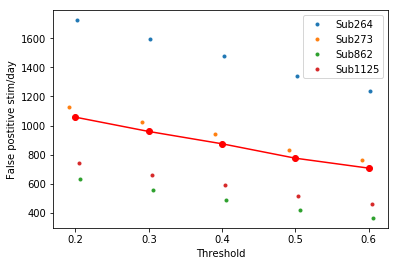

In [19]:
# Plot False Positive Stimulations/Day
plt.figure(2)
plt.clf()
plt.plot(try_thresh,np.mean(fp_per_day,axis=0),'ro-')
for sub_ct in range(n_subs):
    plt.plot(try_thresh+(np.random.rand(1)-.5)/50,fp_per_day[sub_ct,:],'.',label='Sub'+str(subs[sub_ct]))
plt.xlabel('Threshold')
plt.ylabel('False postitive stim/day')
plt.legend()
print('For Thresh: %f' % try_thresh[thresh_id])
print('Mean (SD) False Positive Stim/Day: %f (%f)' % (np.mean(fp_per_day[:,thresh_id]),np.std(fp_per_day[:,thresh_id])))

For Thresh: 0.500000
Mean (SD) Stim Latency: 3.394182 (4.284029) seconds


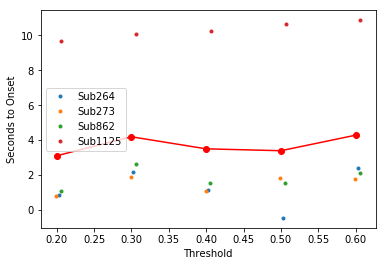

In [21]:
# Plot Mean Stim Latency for each Clinical Szr
plt.figure(3)
plt.clf()
plt.plot(try_thresh,np.mean(mn_stim_lat,axis=0),'ro-')
for sub_ct in range(n_subs):
    plt.plot(try_thresh+(np.random.rand(1)-.5)/50,mn_stim_lat[sub_ct,:],'.',label='Sub'+str(subs[sub_ct]))
plt.xlabel('Threshold')
plt.ylabel('Seconds to Onset')
plt.legend()
print('For Thresh: %f' % try_thresh[thresh_id])
print('Mean (SD) Stim Latency: %f (%f) seconds' % (np.mean(mn_stim_lat[:,thresh_id]),
                                                      np.std(mn_stim_lat[:,thresh_id])))

In [23]:
# Output key results as text
# Report total hours of EEG & # of clinical szrs
print('Total hours of test data: %f' % np.sum(total_hrs))
print('Total days of test data: %f' % np.sum(total_hrs/24))
print('Mean (SD) days of test data: %f (%f)' % (np.mean(total_hrs/24),np.std(total_hrs/24)))
print('Total # of clinical szrs: %d' % np.sum(total_clin_szrs))
print('Mean (SD) # of clinical szrs: %f (%f)' % (np.mean(total_clin_szrs),np.std(total_clin_szrs)))

print()
print('For Thresh: %f' % try_thresh[thresh_id])
print('Mean (SD) Stim Latency: %f (%f) seconds' % (np.mean(mn_stim_lat[:,thresh_id]),
                                                      np.std(mn_stim_lat[:,thresh_id])))
print('Mean (SD) False Positive Stim/Day: %f (%f)' % (np.mean(fp_per_day[:,thresh_id]),np.std(fp_per_day[:,thresh_id])))
print('Mean (SD) Sensitivity: %f (%f)' % (np.mean(sens[:,thresh_id]),np.std(sens[:,thresh_id])))

Total hours of test data: 689.958524
Total days of test data: 28.748272
Mean (SD) days of test data: 7.187068 (1.478903)
Total # of clinical szrs: 36
Mean (SD) # of clinical szrs: 9.000000 (2.915476)

For Thresh: 0.500000
Mean (SD) Stim Latency: 3.394182 (4.284029) seconds
Mean (SD) False Positive Stim/Day: 774.938479 (359.782483)
Mean (SD) Sensitivity: 1.000000 (0.000000)
